In [1]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model1 = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 250),
            nn.Tanh(),
#             nn.Linear(50, 10),
#             nn.Tanh(),
#             nn.Linear(100, 100),
#             nn.Tanh(),
#             nn.Linear(100, 100),
#             nn.Tanh(),
#             nn.Linear(100, 100),
#             nn.Tanh(),
            nn.Linear(250, 2)
        )
    
    def forward(self, x):
        output = self.model1(x)
        return output

    
class MSE0b(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        output = torch.sum((x - y) ** 2)/len(x)
        return output

    
class MSEf(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        output = torch.sum(x ** 2)/len(x)
        return output

torch.manual_seed(1)
sumlog = "PINN my test7 train log"
# 模型初始化
pinn = PINN().cuda()
# nn.init.constant_(pinn.model1[0].weight, 0)
# nn.init.constant_(pinn.model1[0].weight[0:5,0:1], 1)
# nn.init.constant_(pinn.model1[0].weight[5:,1:2], 1)
# pinn.model1[0].weight.requires_grad = False
# print(pinn.model1[0].weight.requires_grad)
optimizer = torch.optim.LBFGS(pinn.parameters(), lr=0.2)
init_loss = MSE0b().cuda()
boundary_loss = MSE0b().cuda()
internal_loss = MSEf().cuda()

In [3]:
# 初值训练点
N0 = 500
init_data = (torch.rand(N0, 2) - 0.5) * 10
init_data[:, 0:1] = torch.zeros((N0, 1))
init_data = init_data.cuda()

init_target = torch.zeros((N0, 2))
init_target[:, 0:1] = 2 / torch.cosh(init_data[:, 1:2])
init_target = init_target.cuda()

# 边界训练点
Nb = 500
sample_time = torch.rand((Nb, 1))*torch.pi/2
bd1_data = torch.full((Nb, 2), 5.)
bd1_data[:, 0:1] = sample_time
bd2_data = torch.full((Nb, 2), -5.)
bd2_data[:, 0:1] = sample_time
bd1_data = bd1_data.cuda()
bd2_data = bd2_data.cuda()

# 内部训练点
Nf = 25000
sample_x = (torch.rand(Nf, 1) - 0.5) * 10
sample_time2 = torch.rand((Nf, 1))*torch.pi/2
internal_data = torch.zeros((Nf, 2))
internal_data[:, 0:1] = sample_time2
internal_data[:, 1:2] = sample_x
internal_data = internal_data.cuda()

# 求导梯度
bd_u_grad_out = torch.Tensor([[1, 0]*Nb]).reshape((-1, 2)).cuda()
bd_v_grad_out = torch.Tensor([[0, 1]*Nb]).reshape((-1, 2)).cuda()

internal_u_grad_out = torch.Tensor([[1, 0]*Nf]).reshape((-1, 2)).cuda()
internal_v_grad_out = torch.Tensor([[0, 1]*Nf]).reshape((-1, 2)).cuda()

In [4]:
pinn.train()
def closure():
    # 初值误差
    init_data_ = init_data.clone()
    init_data_.requires_grad_()
    init_y = pinn(init_data_)
    mse0 = init_loss(init_y, init_target)

    # 边值误差
    bd1_data_ = bd1_data.clone()
    bd1_data_.requires_grad_()
    bd2_data_ = bd2_data.clone()
    bd2_data_.requires_grad_()
    bd1_y = pinn(bd1_data_)
    bd2_y = pinn(bd2_data_)

    bd1_dudx = torch.autograd.grad(outputs=bd1_y, inputs=bd1_data_, grad_outputs=bd_u_grad_out, create_graph=True)[0][:, 1:2]
    bd1_dvdx = torch.autograd.grad(outputs=bd1_y, inputs=bd1_data_, grad_outputs=bd_v_grad_out, create_graph=True)[0][:, 1:2]

    bd2_dudx = torch.autograd.grad(outputs=bd2_y, inputs=bd2_data_, grad_outputs=bd_u_grad_out, create_graph=True)[0][:, 1:2]
    bd2_dvdx = torch.autograd.grad(outputs=bd2_y, inputs=bd2_data_, grad_outputs=bd_v_grad_out, create_graph=True)[0][:, 1:2]

    mseb = boundary_loss(bd1_dudx, bd2_dudx) + boundary_loss(bd1_dvdx, bd2_dvdx)

    # 内点误差
    internal_data_ = internal_data.clone()
    internal_data_.requires_grad_()
    internal_y = pinn(internal_data_)

    internal_du = torch.autograd.grad(outputs=internal_y, inputs=internal_data_, grad_outputs=internal_u_grad_out, create_graph=True)[0]
    internal_dv = torch.autograd.grad(outputs=internal_y, inputs=internal_data_, grad_outputs=internal_v_grad_out, create_graph=True)[0]

    internal_dudt = internal_du[:, 0:1]
    internal_dudx = internal_du[:, 1:2]
    internal_dvdt = internal_dv[:, 0:1]
    internal_dvdx = internal_dv[:, 1:2]

    internal_ddudxx = torch.autograd.grad(outputs=internal_dudx, inputs=internal_data_, grad_outputs=torch.ones_like(internal_dudx), create_graph=True)[0][:, 1:2]
    internal_ddvdxx = torch.autograd.grad(outputs=internal_dvdx, inputs=internal_data_, grad_outputs=torch.ones_like(internal_dudx), create_graph=True)[0][:, 1:2]

    uv_square = internal_y[:, 0:1] ** 2 + internal_y[:, 1:2] ** 2
    f_real = 0.5 * internal_ddudxx - internal_dvdt + uv_square * internal_y[:, 0:1]
    f_imag = 0.5 * internal_ddvdxx + internal_dudt + uv_square * internal_y[:, 1:2]

    msef = internal_loss(f_real) + internal_loss(f_imag)

    # 总共误差
    total_mse = mse0 + mseb + msef

    # 清空梯度+反向传播
    optimizer.zero_grad()
    total_mse.backward()
    
    return total_mse


In [5]:
writer = SummaryWriter(sumlog)
temp = "50-250-5b5b2.5w"
train_err_name = "train " + temp
err_name = "L2 error " + temp
for epoch in range(1000):
    if epoch % 10 == 0 :
        print("Epoch: {}".format(epoch))
#     optimizer.step(closure)
    writer.add_scalar(train_err_name, optimizer.step(closure).item(), epoch)
#     print(optimizer.step(closure).item())
writer.close()

Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Epoch: 110
Epoch: 120
Epoch: 130
Epoch: 140
Epoch: 150
Epoch: 160
Epoch: 170
Epoch: 180
Epoch: 190
Epoch: 200
Epoch: 210
Epoch: 220
Epoch: 230
Epoch: 240
Epoch: 250
Epoch: 260
Epoch: 270
Epoch: 280
Epoch: 290
Epoch: 300
Epoch: 310
Epoch: 320
Epoch: 330
Epoch: 340
Epoch: 350
Epoch: 360
Epoch: 370
Epoch: 380
Epoch: 390
Epoch: 400
Epoch: 410
Epoch: 420
Epoch: 430
Epoch: 440
Epoch: 450
Epoch: 460
Epoch: 470
Epoch: 480
Epoch: 490
Epoch: 500
Epoch: 510
Epoch: 520
Epoch: 530
Epoch: 540
Epoch: 550
Epoch: 560
Epoch: 570
Epoch: 580
Epoch: 590
Epoch: 600
Epoch: 610
Epoch: 620
Epoch: 630
Epoch: 640
Epoch: 650
Epoch: 660
Epoch: 670
Epoch: 680
Epoch: 690
Epoch: 700
Epoch: 710
Epoch: 720
Epoch: 730
Epoch: 740
Epoch: 750
Epoch: 760
Epoch: 770
Epoch: 780
Epoch: 790
Epoch: 800
Epoch: 810
Epoch: 820
Epoch: 830
Epoch: 840
Epoch: 850
Epoch: 860
Epoch: 870
Epoch: 880
Epoch: 890
Epoch: 900
Epoch: 910

In [6]:
torch.save(pinn.state_dict(), "MyModel/model_test7-" + temp + ".pth")

0.20459185455939216


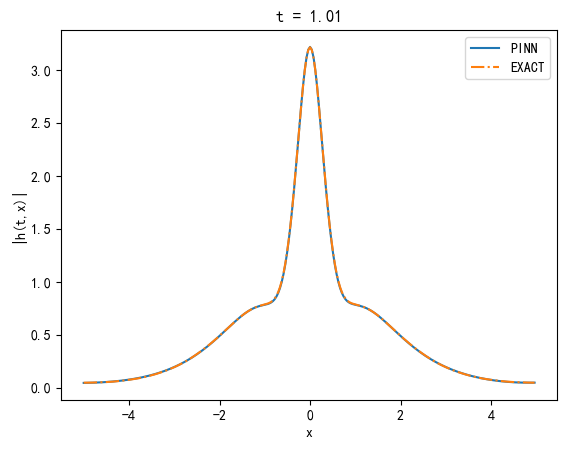

In [28]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
import bisect
import numpy as np

exact_data = loadmat("NLS.mat")
idx = bisect.bisect_right(exact_data['tt'][0], 1)
t = exact_data['tt'][0][idx]
x = exact_data['uu'][:, idx]
x_axis = exact_data['x'][0]

pinn.train(False)

with torch.no_grad():
    test_data = torch.full((len(x), 2), t)
    test_data[:, 1:2] = torch.tensor(exact_data['x'].T)
    test_data = test_data.cuda()
    result = pinn(test_data).cpu()
    rst_abs = torch.sqrt(result[:,0:1]**2 + result[:, 1:2]**2)[:, 0]
    test_data = test_data.cpu()
    real_part = np.asarray(result[:, 0])
    imag_part = np.asarray(result[:, 1])
    ext_real, ext_imag = x.real, x.imag
    err = np.sqrt(((np.abs(real_part - ext_real)**2).sum()+ (np.abs(imag_part - ext_imag)**2).sum()))
    print(err)
    plt.plot(x_axis, rst_abs, label="PINN")
    plt.plot(x_axis, np.abs(x), label="EXACT", linestyle="-.")
    plt.xlabel("x")
    plt.ylabel("|h(t,x)|")
    plt.title("t = {:.2f}".format(t))
    plt.legend()
    plt.show()

In [8]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
import bisect
import numpy as np
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False

exact_data = loadmat("NLS.mat")
idx = bisect.bisect_right(exact_data['tt'][0], 1)
t = exact_data['tt'][0][idx]
x = exact_data['uu'][:, idx]
x_axis = exact_data['x'][0]

errors = []
writer = SummaryWriter(sumlog)
for epoch in range(1000, 1600):
    if epoch % 10 == 0 :
        pinn.train(False)
        print("Epoch: {}, begin evaluation.".format(epoch))
        with torch.no_grad():
            test_data = torch.full((len(x), 2), t)
            test_data[:, 1:2] = torch.tensor(exact_data['x'].T)
            test_data = test_data.cuda()
            result = pinn(test_data).cpu()
            real_part = np.asarray(result[:, 0])
            imag_part = np.asarray(result[:, 1])
            ext_real, ext_imag = x.real, x.imag
            err = np.sqrt((np.abs(real_part - ext_real)**2).sum()+ (np.abs(imag_part - ext_imag)**2).sum())
            writer.add_scalar(err_name, err, epoch)
            errors.append(err)
        pinn.train()
    optimizer.step(closure)
    writer.add_scalar(train_err_name, optimizer.step(closure).item(), epoch)

writer.close()

Epoch: 1000, begin evaluation.
Epoch: 1010, begin evaluation.
Epoch: 1020, begin evaluation.
Epoch: 1030, begin evaluation.
Epoch: 1040, begin evaluation.
Epoch: 1050, begin evaluation.
Epoch: 1060, begin evaluation.
Epoch: 1070, begin evaluation.
Epoch: 1080, begin evaluation.
Epoch: 1090, begin evaluation.
Epoch: 1100, begin evaluation.
Epoch: 1110, begin evaluation.
Epoch: 1120, begin evaluation.
Epoch: 1130, begin evaluation.
Epoch: 1140, begin evaluation.
Epoch: 1150, begin evaluation.
Epoch: 1160, begin evaluation.
Epoch: 1170, begin evaluation.
Epoch: 1180, begin evaluation.
Epoch: 1190, begin evaluation.
Epoch: 1200, begin evaluation.
Epoch: 1210, begin evaluation.
Epoch: 1220, begin evaluation.
Epoch: 1230, begin evaluation.
Epoch: 1240, begin evaluation.
Epoch: 1250, begin evaluation.
Epoch: 1260, begin evaluation.
Epoch: 1270, begin evaluation.
Epoch: 1280, begin evaluation.
Epoch: 1290, begin evaluation.
Epoch: 1300, begin evaluation.
Epoch: 1310, begin evaluation.
Epoch: 1

In [10]:
flag = True
weight_arr = None
bias_arr = None
for item in pinn.model1[0].state_dict().items():
    if flag:
        weight_arr = np.asarray(item[1].cpu())
        flag = False
    else:
        bias_arr = np.asarray(item[1].cpu())

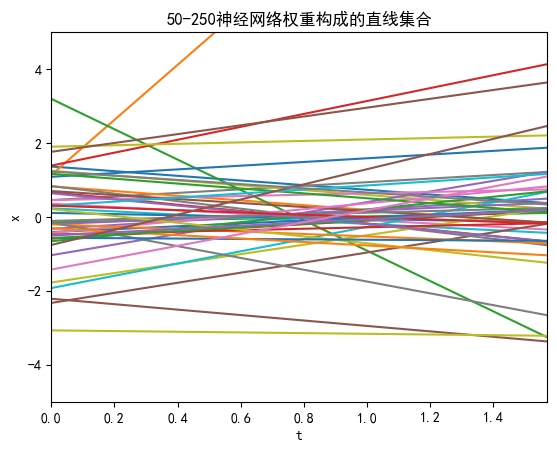

In [12]:
for i in range(len(bias_arr)):
    if (weight_arr[i][0] != 0):
        plt.plot([-(bias_arr[i]-5*weight_arr[i][1])/weight_arr[i][0], -(bias_arr[i]+5*weight_arr[i][1])/weight_arr[i][0]], [-5, 5])
    else:
        plt.plot([0, np.pi/2], [-bias_arr[i] / weight_arr[i][1], -bias_arr[i] / weight_arr[i][1]])

plt.xlim(0, np.pi/2)
plt.ylim(-5, 5)
plt.xlabel("t")
plt.ylabel("x")
plt.title("50-250神经网络权重构成的直线集合")
plt.show()

In [15]:
pinn(test_data)

tensor([[ 3.5038e-02,  2.6164e-02],
        [ 3.5014e-02,  2.6638e-02],
        [ 3.5062e-02,  2.7117e-02],
        [ 3.5179e-02,  2.7602e-02],
        [ 3.5373e-02,  2.8094e-02],
        [ 3.5645e-02,  2.8594e-02],
        [ 3.5994e-02,  2.9105e-02],
        [ 3.6427e-02,  2.9623e-02],
        [ 3.6937e-02,  3.0156e-02],
        [ 3.7534e-02,  3.0698e-02],
        [ 3.8214e-02,  3.1256e-02],
        [ 3.8982e-02,  3.1827e-02],
        [ 3.9839e-02,  3.2414e-02],
        [ 4.0789e-02,  3.3019e-02],
        [ 4.1829e-02,  3.3641e-02],
        [ 4.2967e-02,  3.4281e-02],
        [ 4.4198e-02,  3.4947e-02],
        [ 4.5530e-02,  3.5635e-02],
        [ 4.6962e-02,  3.6346e-02],
        [ 4.8499e-02,  3.7087e-02],
        [ 5.0136e-02,  3.7856e-02],
        [ 5.1886e-02,  3.8658e-02],
        [ 5.3743e-02,  3.9490e-02],
        [ 5.5714e-02,  4.0357e-02],
        [ 5.7801e-02,  4.1262e-02],
        [ 6.0003e-02,  4.2207e-02],
        [ 6.2323e-02,  4.3196e-02],
        [ 6.4767e-02,  4.422

In [27]:

    

x = test_data
for i in range(4):
    x = pinn.model1[i](x)
print(x)

tensor([[-0.9167,  0.1282, -0.5421,  ...,  0.7618,  0.2662,  0.9947],
        [-0.9166,  0.1284, -0.5419,  ...,  0.7620,  0.2672,  0.9947],
        [-0.9165,  0.1285, -0.5418,  ...,  0.7623,  0.2683,  0.9947],
        ...,
        [ 0.9661,  0.5638,  0.3080,  ..., -0.4431,  0.5155, -0.9921],
        [ 0.9659,  0.5619,  0.3097,  ..., -0.4428,  0.5134, -0.9921],
        [ 0.9658,  0.5599,  0.3114,  ..., -0.4426,  0.5113, -0.9921]],
       device='cuda:0', grad_fn=<TanhBackward0>)


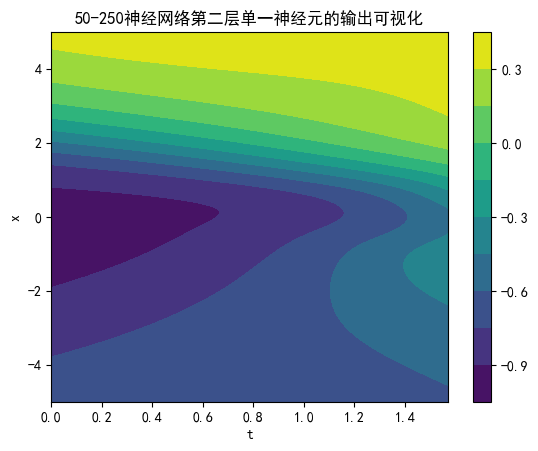

In [88]:
result = np.zeros((ttt.shape[0], ttt.shape[1]))
ttt, xxx = np.meshgrid(exact_data['tt'][0], exact_data['x'][0])
with torch.no_grad():
    for i in range(ttt.shape[0]):
        inputdata = torch.Tensor([[ttt[i][j], xxx[i][j]] for j in range(ttt.shape[1])]).cuda()
        for j in range(4):
            inputdata = pinn.model1[j](inputdata)
        result[i] = np.array(inputdata[:, 200].cpu())
plt.contourf(ttt, xxx, result, levels=12)
plt.colorbar()
plt.xlim(0, np.pi/2)
plt.ylim(-5, 5)
plt.xlabel("t")
plt.ylabel("x")
plt.title("50-250神经网络第二层单一神经元的输出可视化")
plt.show()